# Computing Mutual Information

In [2]:
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras.backend as K
from collections import defaultdict, OrderedDict
import seaborn as sns
sns.set_style('darkgrid')

# Saxe imports
import sys
sys.path.insert(0, '../estimators')
import utils
import kde
import simplebinmi

In [3]:
def load_obj(name):
    with open('../training_files/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Auxiliary functions for KDE estimator

In [4]:
# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 0.001                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

In [5]:
# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

In [6]:
DO_BINNED = True

In [7]:
DO_LOWER

False

## Training information

In [8]:
#training_info = load_obj('tishby_mini_batch')
training_info = load_obj('tishby_mini_batch_new_try')

In [9]:
training_info['data'][0]['activity'][0]

array([[-0.21686125,  0.16286549, -0.16903348, ...,  0.02131339,
         0.06163784,  0.05900906],
       [-0.19320351,  0.1165977 , -0.19917767, ...,  0.05320167,
        -0.07941616,  0.10361613],
       [-0.30958596, -0.01672176,  0.08271845, ...,  0.12356245,
         0.10584626,  0.00662265],
       ...,
       [-0.16706693,  0.3029858 ,  0.2274496 , ...,  0.41721192,
         0.24074507, -0.2660853 ],
       [-0.18468481,  0.2189357 ,  0.37375546, ...,  0.47864327,
         0.5341764 , -0.36429968],
       [-0.3292049 ,  0.37856564,  0.19902642, ...,  0.4481321 ,
         0.3561674 , -0.33015323]], dtype=float32)

In [10]:
training_info['data'][1199]['activity'][0]

array([[-0.94725275,  0.9731736 , -0.0539842 , ...,  0.407846  ,
         0.90685374,  0.8307307 ],
       [-0.8522875 ,  0.90858585, -0.9961365 , ...,  0.66046345,
         0.91537637,  0.04281834],
       [-0.45675054,  0.7226585 ,  0.7633363 , ...,  0.56684756,
        -0.5959687 ,  0.66242564],
       ...,
       [-0.93098235, -0.12161974,  0.2083056 , ...,  0.949827  ,
         0.9958522 ,  0.5623652 ],
       [-0.95239717,  0.28587717,  0.84963304, ...,  0.08682661,
         0.96298057,  0.7592227 ],
       [-0.6267033 ,  0.8022917 ,  0.7378756 , ..., -0.9452699 ,
        -0.22112553, -0.331809  ]], dtype=float32)

In [11]:
training_info['data'][0]['activity'][-1]

array([[0.5000002 , 0.4999998 ],
       [0.5000004 , 0.4999996 ],
       [0.49999985, 0.5000002 ],
       ...,
       [0.488845  , 0.511155  ],
       [0.4888267 , 0.51117325],
       [0.4888397 , 0.5111603 ]], dtype=float32)

In [12]:
training_info['data'][1199]['activity'][-1]

array([[9.6440663e-06, 9.9999034e-01],
       [9.9998248e-01, 1.7526945e-05],
       [9.9998271e-01, 1.7295484e-05],
       ...,
       [1.1638977e-05, 9.9998838e-01],
       [1.9432131e-05, 9.9998057e-01],
       [1.0940282e-05, 9.9998903e-01]], dtype=float32)

## Input data

In [13]:
train, test = utils.get_IB_data('2017_12_21_16_51_3_275766')

In [14]:
train.X

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [15]:
train.X.shape

(3277, 12)

In [16]:
train.Y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [17]:
train.Y.shape

(3277, 2)

In [18]:
train.y

array([1, 0, 1, ..., 0, 1, 0], dtype=uint8)

In [19]:
train.y.shape

(3277,)

### Label dictionary `saved_labelixs` 

In [20]:
# Save indexes of tests data for each of the output classes
saved_labelixs = {}
FULL_MI = False
NUM_LABELS = 2

y = train.y
Y = train.Y

#y = test.y
#Y = test.Y

if FULL_MI:
    full = utils.construct_full_dataset(train,test)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

In [21]:
labelprobs

array([0.48672566, 0.5132743 ], dtype=float32)

## Computing MI

In [22]:
training_info.keys()

dict_keys(['epoch', 'loss', 'loss_gen', 'data'])

In [23]:
len(training_info['data'])

1200

In [24]:
len(training_info['data'])

1200

In [25]:
activity = training_info['data'][1199]['activity'][5]
activity

array([[9.6440663e-06, 9.9999034e-01],
       [9.9998248e-01, 1.7526945e-05],
       [9.9998271e-01, 1.7295484e-05],
       ...,
       [1.1638977e-05, 9.9998838e-01],
       [1.9432131e-05, 9.9998057e-01],
       [1.0940282e-05, 9.9998903e-01]], dtype=float32)

### Take a look to full batch and compare

In [48]:
training_info_full = load_obj('tishby_epoch_8000_loss_019906')

In [50]:
activity_full = training_info_full['data'][7999]['activity'][5]
activity_full

array([[0.00944319, 0.99055684],
       [0.5042464 , 0.49575353],
       [0.07286023, 0.92713976],
       ...,
       [0.98710144, 0.01289854],
       [0.0158016 , 0.9841984 ],
       [0.98747414, 0.01252583]], dtype=float32)

In [53]:
print(len(activity))
print(len(activity_full))

3277
3277


In [55]:
np.rint(activity)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [59]:
np.sum(np.rint(activity), axis=0)

array([1595., 1682.], dtype=float32)

In [60]:
np.sum(np.rint(activity_full), axis=0)

array([1565., 1712.], dtype=float32)

### Calculating for the last layer and last epoch

In [61]:
h_upper = entropy_func_upper([activity, ])[0]
h_upper

-3.3770828

In [63]:
h_upper = entropy_func_upper([activity_full, ])[0]
h_upper

-1.9186409

In [42]:
hM_given_Y_upper= 0.0
NUM_LABELS = 2
for i in range(NUM_LABELS):
    hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
    print(hcond_upper)
    print(labelprobs[i])
    print(saved_labelixs[i])
    print('---------')
    hM_given_Y_upper += labelprobs[i] * hcond_upper

-3.3770614
0.48672566
[False  True False ...  True False  True]
---------
-3.3771057
0.5132743
[ True False  True ... False  True False]
---------


In [64]:
hM_given_Y_upper= 0.0
NUM_LABELS = 2
for i in range(NUM_LABELS):
    hcond_upper = entropy_func_upper([activity_full[saved_labelixs[i],:],])[0]
    print(hcond_upper)
    print(labelprobs[i])
    print(saved_labelixs[i])
    print('---------')
    hM_given_Y_upper += labelprobs[i] * hcond_upper

-2.425697
0.48672566
[False  True False ...  True False  True]
---------
-2.436992
0.5132743
[ True False  True ... False  True False]
---------


In [65]:
hM_given_Y_upper

-2.431494355201721

In [66]:
h_upper - hM_given_Y_upper

0.5128535032272339

In [26]:
#### This is an auxiliary dictionary to store the results for each epoch
# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}
#measures['relu'] = {}
PLOT_LAYERS    = None 
NUM_LABELS = 2


#### Main loop: over epochs

for epoch in range(0, len(training_info['data']), 20):
#for epoch in range(0, 1):
    
    cepochdata = defaultdict(list) 
    
    #training_info['data'][epoch]
    
    print('---- EPOCH %d' % epoch)
    
    
    #####################################################################
    num_layers = len(training_info['data'][epoch]['activity'])

    if PLOT_LAYERS is None:
        PLOT_LAYERS = []
        for lndx in range(num_layers):
            #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
            PLOT_LAYERS.append(lndx)
    #####################################################################
    
    for layer in range(len(training_info['data'][epoch]['activity'])):
        
        activity = training_info['data'][epoch]['activity'][layer] 
        
        #print(epoch)
        #print(layer)
        #print(activity)
        #break
        
        #### Compute marginal entropies
        h_upper = entropy_func_upper([activity, ])[0]
        if DO_LOWER: # Why computing lower bound would not be necessary?
            h_lower = entropy_func_lower([activity, ])[0]
            
        #### Layer activity given input. This is simply the entropy of the Gaussian noise
        hM_given_X = kde.kde_condentropy(activity, noise_variance)
        
        #### Compute conditional entropies of layer activity output
        hM_given_Y_upper= 0.0
        for i in range(NUM_LABELS):
            hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
            hM_given_Y_upper += labelprobs[i] * hcond_upper
            
        if DO_LOWER:
            hM_given_Y_lower=0.0
            for i in range(NUM_LABELS):
                hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_lower += labelprobs[i] * hcond_lower
                
        cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
        cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
        cepochdata['H_M_upper'  ].append( nats2bits * h_upper )
        pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], 
                                                        cepochdata['MI_YM_upper'][-1])
        
        #print(cepochdata)
        
        ### Compute lower bounds
        if DO_LOWER: 
            cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
            cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
            cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
            pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], 
                                                                cepochdata['MI_YM_lower'][-1])
        ### Compute binned estimates
        if DO_BINNED:
            binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
            cepochdata['MI_XM_bin'].append( nats2bits * binxm )
            cepochdata['MI_YM_bin'].append( nats2bits * binym )
            pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], 
                                                              cepochdata['MI_YM_bin'][-1])
            
        print('- Layer %d %s' % (layer, pstr) )
        
    measures['tanh'][epoch] = cepochdata
        

---- EPOCH 0
- Layer 0 upper: MI(X;M)=11.658, MI(Y;M)=0.991 | bin: MI(X;M)=11.677, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=2.621, MI(Y;M)=0.004 | bin: MI(X;M)=5.473, MI(Y;M)=0.034
- Layer 2 upper: MI(X;M)=0.880, MI(Y;M)=0.000 | bin: MI(X;M)=1.692, MI(Y;M)=0.005
- Layer 3 upper: MI(X;M)=0.592, MI(Y;M)=0.000 | bin: MI(X;M)=1.491, MI(Y;M)=0.005
- Layer 4 upper: MI(X;M)=0.352, MI(Y;M)=0.000 | bin: MI(X;M)=1.903, MI(Y;M)=0.002
- Layer 5 upper: MI(X;M)=0.062, MI(Y;M)=0.000 | bin: MI(X;M)=0.958, MI(Y;M)=0.000
---- EPOCH 20
- Layer 0 upper: MI(X;M)=11.672, MI(Y;M)=0.996 | bin: MI(X;M)=11.676, MI(Y;M)=0.998
- Layer 1 upper: MI(X;M)=5.009, MI(Y;M)=0.014 | bin: MI(X;M)=6.403, MI(Y;M)=0.077
- Layer 2 upper: MI(X;M)=4.703, MI(Y;M)=0.010 | bin: MI(X;M)=5.442, MI(Y;M)=0.025
- Layer 3 upper: MI(X;M)=4.677, MI(Y;M)=0.009 | bin: MI(X;M)=4.984, MI(Y;M)=0.020
- Layer 4 upper: MI(X;M)=4.777, MI(Y;M)=0.011 | bin: MI(X;M)=4.946, MI(Y;M)=0.015
- Layer 5 upper: MI(X;M)=3.224, MI(Y;M)=0.005 | bin: MI(X;M)=3.771,

- Layer 3 upper: MI(X;M)=5.383, MI(Y;M)=0.014 | bin: MI(X;M)=5.297, MI(Y;M)=0.029
- Layer 4 upper: MI(X;M)=5.120, MI(Y;M)=0.013 | bin: MI(X;M)=5.238, MI(Y;M)=0.016
- Layer 5 upper: MI(X;M)=2.029, MI(Y;M)=0.003 | bin: MI(X;M)=2.259, MI(Y;M)=0.003
---- EPOCH 340
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999 | bin: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.590, MI(Y;M)=0.953 | bin: MI(X;M)=11.637, MI(Y;M)=0.979
- Layer 2 upper: MI(X;M)=6.336, MI(Y;M)=0.027 | bin: MI(X;M)=7.438, MI(Y;M)=0.072
- Layer 3 upper: MI(X;M)=5.425, MI(Y;M)=0.012 | bin: MI(X;M)=5.401, MI(Y;M)=0.022
- Layer 4 upper: MI(X;M)=5.064, MI(Y;M)=0.011 | bin: MI(X;M)=5.215, MI(Y;M)=0.020
- Layer 5 upper: MI(X;M)=1.988, MI(Y;M)=0.006 | bin: MI(X;M)=2.206, MI(Y;M)=0.009
---- EPOCH 360
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999 | bin: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.601, MI(Y;M)=0.963 | bin: MI(X;M)=11.653, MI(Y;M)=0.985
- Layer 2 upper: MI(X;M)=6.367, MI(Y;M)=0.031 | bin: MI(X;M)

- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999 | bin: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.632, MI(Y;M)=0.978 | bin: MI(X;M)=11.662, MI(Y;M)=0.992
- Layer 2 upper: MI(X;M)=6.475, MI(Y;M)=0.036 | bin: MI(X;M)=7.413, MI(Y;M)=0.097
- Layer 3 upper: MI(X;M)=5.219, MI(Y;M)=0.014 | bin: MI(X;M)=5.254, MI(Y;M)=0.027
- Layer 4 upper: MI(X;M)=4.248, MI(Y;M)=0.015 | bin: MI(X;M)=4.299, MI(Y;M)=0.020
- Layer 5 upper: MI(X;M)=1.574, MI(Y;M)=0.007 | bin: MI(X;M)=1.707, MI(Y;M)=0.010
---- EPOCH 680
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999 | bin: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.635, MI(Y;M)=0.977 | bin: MI(X;M)=11.659, MI(Y;M)=0.989
- Layer 2 upper: MI(X;M)=6.468, MI(Y;M)=0.035 | bin: MI(X;M)=7.428, MI(Y;M)=0.096
- Layer 3 upper: MI(X;M)=5.175, MI(Y;M)=0.017 | bin: MI(X;M)=5.293, MI(Y;M)=0.032
- Layer 4 upper: MI(X;M)=4.093, MI(Y;M)=0.015 | bin: MI(X;M)=4.112, MI(Y;M)=0.024
- Layer 5 upper: MI(X;M)=1.535, MI(Y;M)=0.005 | bin: MI(X;M)=1.657, MI(Y;M)

- Layer 1 upper: MI(X;M)=11.645, MI(Y;M)=0.983 | bin: MI(X;M)=11.662, MI(Y;M)=0.990
- Layer 2 upper: MI(X;M)=6.384, MI(Y;M)=0.036 | bin: MI(X;M)=7.381, MI(Y;M)=0.106
- Layer 3 upper: MI(X;M)=4.609, MI(Y;M)=0.013 | bin: MI(X;M)=4.770, MI(Y;M)=0.023
- Layer 4 upper: MI(X;M)=3.495, MI(Y;M)=0.009 | bin: MI(X;M)=3.688, MI(Y;M)=0.017
- Layer 5 upper: MI(X;M)=1.346, MI(Y;M)=0.004 | bin: MI(X;M)=1.440, MI(Y;M)=0.008
---- EPOCH 1000
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999 | bin: MI(X;M)=11.678, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.651, MI(Y;M)=0.987 | bin: MI(X;M)=11.665, MI(Y;M)=0.993
- Layer 2 upper: MI(X;M)=6.366, MI(Y;M)=0.037 | bin: MI(X;M)=7.358, MI(Y;M)=0.106
- Layer 3 upper: MI(X;M)=4.605, MI(Y;M)=0.014 | bin: MI(X;M)=4.841, MI(Y;M)=0.030
- Layer 4 upper: MI(X;M)=3.529, MI(Y;M)=0.013 | bin: MI(X;M)=3.805, MI(Y;M)=0.018
- Layer 5 upper: MI(X;M)=1.372, MI(Y;M)=0.004 | bin: MI(X;M)=1.464, MI(Y;M)=0.004
---- EPOCH 1020
- Layer 0 upper: MI(X;M)=11.678, MI(Y;M)=0.999 | bin: MI(X;M

In [27]:
DO_SAVE = False

## Plot

/home/rodrigo/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


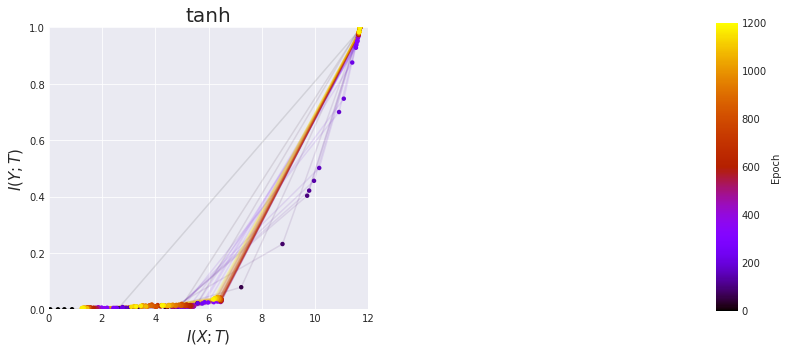

In [28]:
COLORBAR_MAX_EPOCHS= 1200
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    
    #print(vals)
    
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]
        
       
        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('$I(X;T)$', fontsize= 15)
    plt.ylabel('$I(Y;T)$', fontsize= 15)
    plt.title(activation, fontsize= 20)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    #plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')
    plt.savefig('plots/info_plane_no_mini_batch')